In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam, SGD

from torch.distributions import gumbel

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm

from scipy.stats import gaussian_kde
from models.equivariant_mpnn import MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
from pygad import GA

In [3]:
import matplotlib as mpl

In [4]:
plt.rc('font', family='serif',)


In [5]:
from matplotlib import rc

In [38]:
data = get_zeolite('MOR', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MOR')
hoa = hoa[:,0]

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [39]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [40]:
distance_matrix=d

In [41]:
trainX = trainloader.dataset.X.sum((1,2))[:,None].numpy()
trainy = trainloader.dataset.y[:,None].numpy()
testX = testloader.dataset.X.sum((1,2))[:,None].numpy()
testy = testloader.dataset.y[:,None].numpy()

In [42]:
hoa.shape

(5011,)

In [43]:
from sklearn.linear_model import LinearRegression as LR

In [44]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [45]:
yhat = lr.predict(testX)

In [46]:
yhat.shape, testy.shape

((502, 1), (502, 1))

In [47]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [48]:
lr_mse, lr_mae

(6.942721869527675, 1.9998629107436905)

In [49]:
title_size=7.5
label_size=7

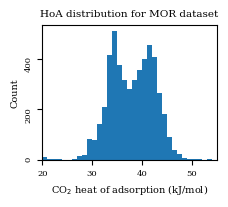

In [50]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(20,55,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for MOR dataset', fontsize=title_size)
plt.xlim(20,55)
plt.savefig('figures/datadist_mor.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [51]:
hoa_x = np.tile(np.linspace(20,55,35)[:,None], (1,12))
hoa_y = np.tile(np.arange(0,12,1)[None], (hoa_x.shape[0],1))


In [52]:
zi = np.zeros((len(hoa_x),12))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum() - 1
    if n_als == -1:
        n_als = 0
              
    for _x in range(0,len(hoa_x)-1):
        
        if hoa_x[_x, n_als] < curr_h <= hoa_x[_x+1, n_als]:
            zi[_x, n_als] += 1

In [53]:
zi = zi/zi.sum(0)[None]

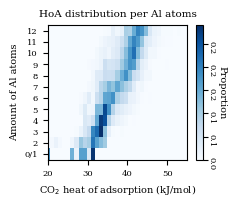

In [54]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')

plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,12,1), ['0/1'] + np.arange(2,13,1).tolist(), fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(20,55)
plt.ylim(-0.5,11.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_mor.pdf', dpi=1200, bbox_inches="tight")
plt.savefig('figures/aldist_mor.png', dpi=1200, bbox_inches="tight")

In [55]:
hoa_x.shape, hoa_y.shape, zi.shape

((35, 12), (35, 12), (35, 12))

In [56]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')


mpnn2 = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, site_pred=True).to('cuda')

In [57]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [58]:
X_pore.shape

(16, 3)

In [59]:
_mae_p = []
_mse_p = []

_mae_p2 = []
_mse_p2 = []


for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/MOR/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p.append(_mae)
    _mse_p.append(_mse)

    mpnn2.load_state_dict(torch.load(f'model_data_random2/MOR/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn2.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p2.append(_mae)
    _mse_p2.append(_mse)


mae_p  = np.mean(_mae_p)
mse_p = np.mean(_mse_p)
mae_p2  = np.mean(_mae_p2)
mse_p2 = np.mean(_mse_p2)


mae_p_ci = get_95_CI(_mae_p)
mse_p_ci = get_95_CI(_mse_p)
mae_p2_ci = get_95_CI(_mae_p2)
mse_p2_ci = get_95_CI(_mse_p2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.16s/it]


In [60]:
mae_p, mae_p2, mse_p, mse_p2

(0.83536137342453, 0.9096058547496796, 1.3037930846214294, 1.4850362062454223)

In [61]:
mae_p_ci, mae_p2_ci, mse_p_ci, mse_p2_ci

(0.03836741560684651,
 0.07605908056426226,
 0.10538284175231341,
 0.1623566894162288)

In [62]:
best_idx = np.argmin(_mae_p2)
mpnn2.load_state_dict(torch.load(f'model_data_random2/MOR/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn2.predict(testloader)

In [63]:
xmin, xmax = 25,50

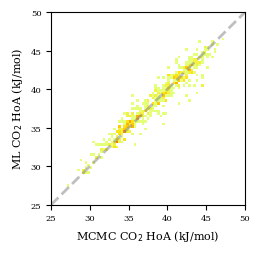

In [64]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
plt.hist2d(y_true, y_pred, bins=75, range=((xmin,xmax),(xmin,xmax)), cmin=1, cmap='Wistia')
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=2, alpha=0.5)
plt.xlabel(f"MCMC CO$_2$ HoA (kJ/mol)", fontsize=8)
plt.ylabel(f"ML CO$_2$ HoA (kJ/mol)", fontsize=8)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6);

In [65]:
data['l']

array([18.256, 20.534,  7.542])

In [66]:
def get_co2(file, l=l):
    with open(file, 'r') as f:
        lines = f.readlines()
    coordinates = []

    for line in lines:
        if line.startswith('ATOM'):
            parts = line.split()
            if parts[2] == 'C':
                x_coord, y_coord, z_coord = map(float, parts[4:7])
                coordinates.append((x_coord, y_coord, z_coord))
    coordinates = torch.tensor(coordinates)
    coordinates = torch.remainder(coordinates, l)/l
    
    return coordinates

def get_atoms(file):

    with open(file) as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = np.array([1 if i[0]=='Al' else 0 for i in at_pos])
    X = np.array([list(map(float, i[1:])) for i in at_pos])
    return torch.tensor(atom), torch.tensor(X)    

In [67]:
def get_edges(X,A):

    edge_x, edge_y = [],[]
    
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i,j] == 1:
                ix, iy = X[i,[0,1]].copy()

                jx, jy = X[j,[0,1]].copy()
            
                if jx - ix > 0.5:
                    jx -= 1
                elif jx - ix < -0.5:
                    jx += 1

                if jy - iy > 0.5:
                    jy -= 1
                elif jy - iy < -0.5:
                    jy += 1

                
                
                edge_x.append((ix,jx))
                edge_y.append((iy,jy))
                
                
    return edge_x, edge_y

def plot_edges(X,A,ax):

    ex, ey = get_edges(X,A)    
    for i in range(len(ex)):

        ax.plot(ex[i], ey[i], c='black', zorder=-100)

    # ax.scatter(eix, eiy)
    # ax.scatter(ejx, ejy, s=100)
    

In [68]:
import matplotlib.colors as mcolors
high_color = 'blue'

# Create a custom colormap that transitions from white (0) to the specified color
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [(0, 'white'), (1, high_color)])

In [69]:
atoms.shape, hoa.shape

((5011, 48), (5011,))

In [70]:
X.shape, hoa.shape

((48, 3), (5011,))

In [71]:
def plot_co2(sample_idx):
    ncols=2
    nrows=len(sample_idx)
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*3), constrained_layout=True)
    
    for i in range(len(sample_idx)):
        idx = sample_idx[i]
        a, _ = get_atoms(f'C:/users/20175552/code/MCMC_gen/data/co2_cifs/MOR_{idx}.cif')
        co2 = get_co2(f'C:/users/20175552/code/MCMC_gen/data/co2/CO2_{idx}.pdb', torch.tensor(data['l']))
    
        #print(sum((atoms==a.numpy()).all(1)))
    
        true_hoa = hoa[(atoms==a.numpy()).all(1)]
        
        mpnn2.eval()
        with torch.no_grad():
            _X[0] = a.unsqueeze(-1)
            hid = mpnn2.forward(_X.float().cuda(), _bonds.float().cuda(), _X_p.float().cuda(), _bonds_sp.float().cuda(), _bonds_ps.float().cuda())[0].cpu().numpy()
    
        pred_hoa = sum(hid)
        
        x = co2[:,0]
        y = co2[:,1]
    
        
        plot_edges(X,A, ax[i,0])
        plot_edges(X,A, ax[i,1])
    
        # xy = np.mod(np.vstack([x,y]))
        # z = gaussian_kde(xy)(xy)
    
        # Sort the points by density, so that the densest points are plotted last
        # idx = z.argsort()
        # x, y, z = x[idx], y[idx], z[idx]
        ax[i,0].hist2d(x,y, bins=75, cmap=cmap, zorder=-1000, vmin=0, vmax=48)
        # h = ax[0].hist2d(x,y, bins=75, cmap=cmap, zorder=-1000)
        # print(h[0].max())
        # ax[0].scatter(x, y, c=z)
        ax[i,0].scatter(X[:,0], X[:,1], c= a,edgecolors='black', cmap='prism')
        ax[i,0].set_xlim(0,1)
        ax[i,0].set_ylim(0,1)
        ax[i,0].set_xticks([],[])
        ax[i,0].set_yticks([],[])
    
    
        ax[i,1].scatter(X[:,0], X[:,1], c= a,edgecolors='black', cmap='prism')
        pr = ax[i,1].scatter(X_pore[:,0], X_pore[:,1], c=hid , s=150, cmap='Reds',edgecolors='black', vmin=0, vmax=12)
        ax[i,1].scatter(X_pore[:,0]+1, X_pore[:,1], c=hid , s=150, cmap='Reds',edgecolors='black', vmin=0, vmax=12)
        ax[i,1].scatter(X_pore[:,0], X_pore[:,1]+1, c=hid , s=150, cmap='Reds',edgecolors='black', vmin=0, vmax=12)
        ax[i,1].scatter(X_pore[:,0]+1, X_pore[:,1]+1, c=hid , s=150, cmap='Reds',edgecolors='black', vmin=0, vmax=12)
        ax[i,1].set_xlim(0,1)
        ax[i,1].set_ylim(0,1)
        ax[i,1].set_xticks([],[])
        ax[i,1].set_yticks([],[])
    
        ax[i,0].set_title(f'MCMC HoA: {true_hoa[0]:.2f} kJ/mol')
        ax[i,1].set_title(f'ML HoA: {pred_hoa[0]:.2f} kJ/mol')
        
        plt.colorbar(pr, ax=ax[i,1])
        
    fig.savefig(f'figures/co2emb.pdf', dpi=600, bbox_inches='tight')
    fig.savefig(f'figures/co2emb.png', dpi=600, bbox_inches='tight')

In [73]:
_X, _bonds, _X_p, _bonds_sp, _bonds_ps, _y = next(iter(testloader))

In [74]:
mpnn2.load_state_dict(torch.load(f'model_data_random2/MOR/1.0/pore/model_10/model.pth'))
pred = mpnn2.forward(_X.float().cuda(), _bonds.float().cuda(), _X_p.float().cuda(), _bonds_sp.float().cuda(), _bonds_ps.float().cuda())

In [75]:
A.shape

(48, 48)

In [76]:
sample_idx = [752, 789, 1200, 1250]

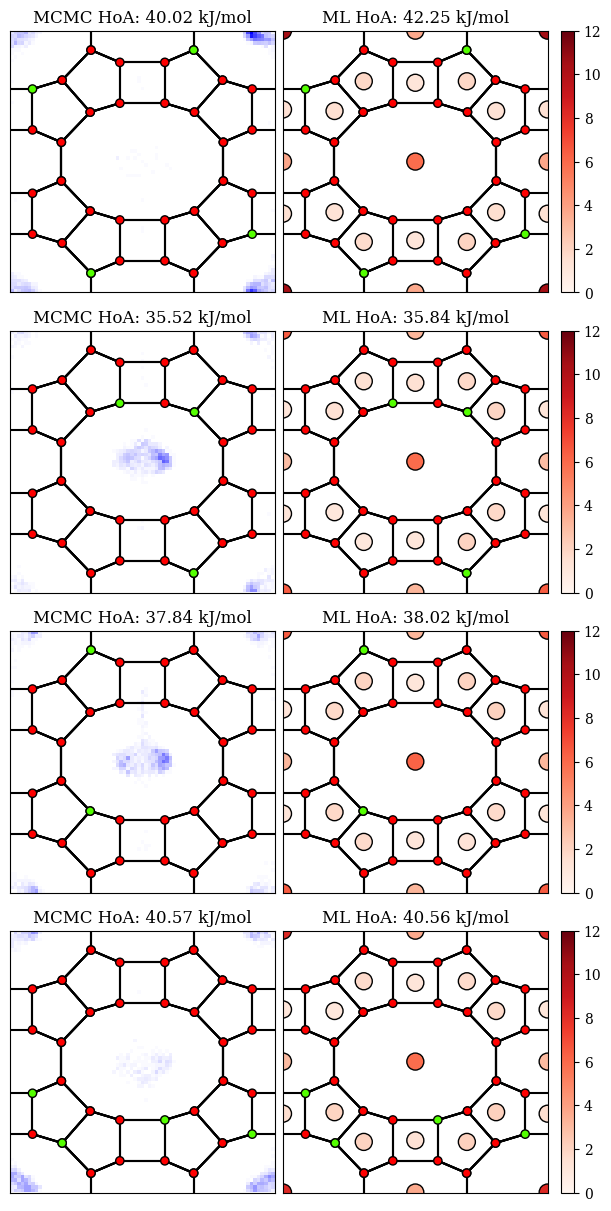

In [79]:
plot_co2(sample_idx)

In [78]:
plot_co2(752)

TypeError: object of type 'int' has no len()

In [ ]:
plot_co2(789)

In [ ]:
plot_co2(1200)

In [ ]:
plot_co2(1250)

In [628]:
atts = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [32]:
_X[0] = atts[:,None]

In [34]:
pred.shape

torch.Size([32, 16, 1])

In [35]:
hid = pred[0].detach().cpu()

In [36]:
hid = hid.abs().sum(1).numpy()

In [37]:
hid

array([ 5.870462 , 10.46753  ,  3.7942216,  3.683197 ,  1.5086545,
        1.8677322,  1.9145256,  1.399326 ,  1.5784422,  2.0089798,
        1.6822431,  1.3269293,  1.1388248,  1.1392348,  1.4062845,
        1.4592973], dtype=float32)

Text(0.5, 1.0, 'Pore activation')

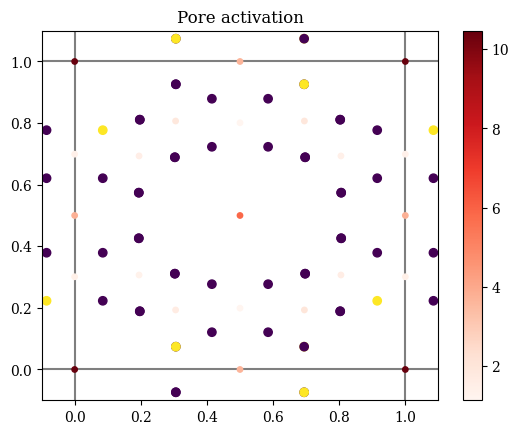

In [38]:

plt.vlines([0,1], -1, 2, color='black', zorder=-200, alpha=0.5)
plt.hlines([0,1], -1, 2, color='black', zorder=-200, alpha=0.5)


plt.scatter(X[:,0], X[:,1], c= atts)
plt.scatter(X[:,0]+1, X[:,1]+1, c= atts)
plt.scatter(X[:,0]+1, X[:,1], c= atts)
plt.scatter(X[:,0], X[:,1]+1, c= atts)


plt.scatter(X[:,0]-1, X[:,1]-1, c= atts)
plt.scatter(X[:,0]-1, X[:,1], c= atts)
plt.scatter(X[:,0], X[:,1]-1, c= atts)

plt.scatter(X_pore[:,0], X_pore[:,1], c= hid, s=15, cmap='Reds')
plt.scatter(X_pore[:,0]+1, X_pore[:,1]+1, c= hid, s=15, cmap='Reds')
plt.scatter(X_pore[:,0]+1, X_pore[:,1], c= hid, s=15, cmap='Reds')
plt.scatter(X_pore[:,0], X_pore[:,1]+1, c= hid, s=15, cmap='Reds')


for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        pass

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.colorbar()
plt.title('Pore activation')

In [39]:
from scipy.interpolate import griddata

In [40]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(25.3737), tensor(48.1192), tensor(20.8601), tensor(48.3556))

In [41]:
atsum=  testloader.dataset.X.sum((1,2))

In [42]:

def get_plot_data(n_ats, hoa):
    x = []
    y = []
    y_ci_min = []
    y_ci_max = []
    for i in np.unique(n_ats):
        _x = hoa[n_ats==i]
    
        x.append(i)
        y.append(np.mean(_x))
    
        b,t = np.quantile(_x, [0.05, 0.95])
        y_ci_min.append(b)
        y_ci_max.append(t)
    return np.array(x),y,y_ci_min, y_ci_max
    

In [43]:
x1, y1, y_ci_min1, y_ci_max1 = get_plot_data(atsum.numpy(), y_pred.numpy())
x2, y2, y_ci_min2, y_ci_max2 = get_plot_data(atsum.numpy(), y_true.numpy())

Text(0, 0.5, 'Heat of Adsoprtion')

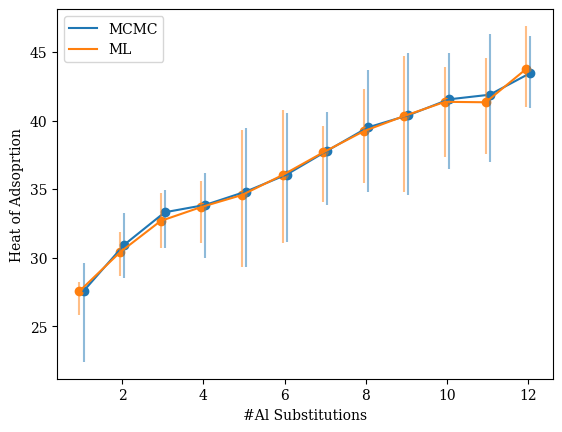

In [44]:
offset = 0.05


plt.scatter(x2+offset,y2)
l2 = plt.plot(x2+offset,y2,label='MCMC')
plt.vlines(x2+offset, y_ci_min2, y_ci_max2,alpha=0.5, color=l2[0].get_c())
plt.scatter(x1-offset,y1)
l1 = plt.plot(x1-offset,y1, label='ML')
plt.vlines(x1-offset, y_ci_min1, y_ci_max1, alpha=0.5, color=l1[0].get_c())



plt.legend(loc='upper left');
plt.xlabel('#Al Substitutions')
plt.ylabel('Heat of Adsoprtion')

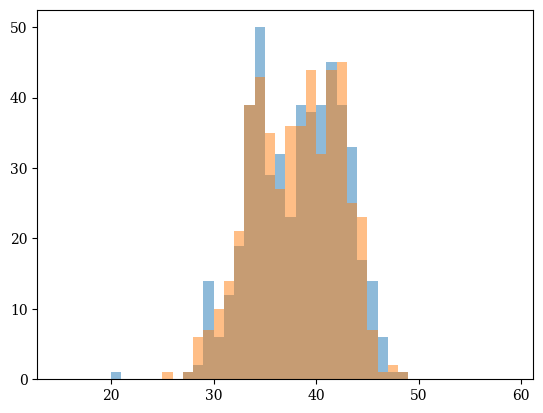

In [45]:
plt.hist(y_true, bins=np.arange(15, 60), alpha=0.5);
plt.hist(y_pred, bins=np.arange(15, 60), alpha=0.5);


In [46]:
Z = torch.ones_like(y_pred)

In [47]:
nn = 60
xmin = 20
xmax = 50
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [48]:
#xi.shape, yi.shape, xi, yi

In [49]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [50]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_14840\4168005689.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


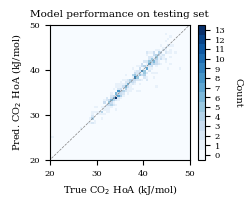

In [51]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange(n_colors/(2*(n_colors+1)), n_colors, n_colors/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

#plt.savefig('figures/truepred.svg', dpi=1200, bbox_inches="tight")
plt.savefig('figures/truepred_mor_int.pdf', dpi=1200, bbox_inches="tight")
plt.savefig('figures/truepred_mor_int.png', dpi=1200, bbox_inches="tight")

In [86]:
color = np.zeros((X.shape[0],))
for i in range(len(X)):
    
    for j in range(4):
        
        for k in range(ref.shape[0]):
            
            if np.abs(X[i] - (np.mod(ref[k]*X[j] + tra[k], 1))).sum() < 0.001:
                
                color[i] = j
                
                break
        

In [87]:
color2 = np.zeros((X_pore.shape[0],))
for i in range(len(X_pore)):
    
    for j in [0,2,4,-1]:
        
        for k in range(ref.shape[0]):
            
            if np.abs(X_pore[i] - (np.mod(ref[k]*X_pore[j] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break

In [88]:
blaa = {'a':1}

'b' in blaa

False

In [89]:
ce_dict = {}
row, col = np.nonzero(A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [90]:
cp_dict = {}
row, col = np.nonzero(A_pore)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X_pore[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

In [91]:
import matplotlib.patheffects as pe

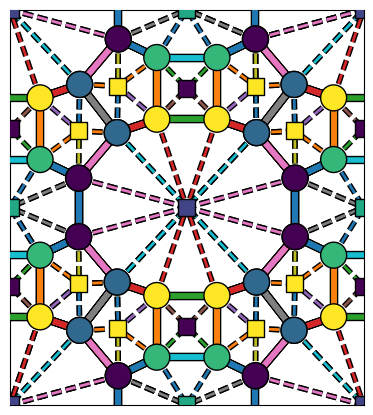

In [92]:
plt.figure(figsize=(18.256/4, 20.534/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=6, c='black', zorder=4)
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= 'black',lw=6, zorder=4)
        x+=1
        
        
for i in cp_dict:
    x = 0
    for j in cp_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X_pore[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        #     line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        
        # plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        x+=1
        

plt.scatter(X_pore[:,0], X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0], X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(X[:,0], X[:,1], c=color, s=350, zorder=10, edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing_pore_mor.pdf', bbox_inches='tight', dpi=1200);
plt.savefig('figures/weight_sharing_pore_mor.png', bbox_inches='tight', dpi=1200);

In [93]:
atsum = testloader.dataset.X.sum((1,2))

In [60]:
hoa_test = testloader.dataset.y

In [61]:
uniq = atsum.unique()

In [62]:
hoa_min = np.zeros_like(uniq, dtype=float)
hoa_max = np.zeros_like(uniq, dtype=float)

In [63]:
for ue in range(len(uniq)):
    hoa_min[ue] = hoa_test[atsum==uniq[ue]].min()
    hoa_max[ue] = hoa_test[atsum==uniq[ue]].max()

In [64]:
uniq[np.logical_and(hoa_min < 30, hoa_max > 30)]

tensor([2, 3, 4, 5, 6])

In [245]:
import torch.nn as nn
class GumbelSigmoid(nn.Module):
    def __init__(self):
        super(GumbelSigmoid, self).__init__()
        
    def forward(self, logit, temperature=1.0, hard=False):
        # Generate Gumbel noise
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(logit)))

        # Combine with logit and temperature
        z = (logit + gumbel_noise) / temperature

        # Apply sigmoid function
        sigmoid_output = torch.sigmoid(z)

        if hard:
            discrete_output = (sigmoid_output > 0.5).float()
            sigmoid_output = sigmoid_output + (discrete_output - sigmoid_output).detach()

        return sigmoid_output


class GeneticNet(nn.Module):

    def __init__(self, mpnn, edges, pore, bonds_sp, bonds_ps):
        
        super().__init__()
        self.bonds = edges[None].float().cuda().repeat(2,1,1)
        self.sites_p = torch.tensor(pore[None]).float().cuda().repeat(2,1,1)
        self.bonds_sp = edges_sp[None].float().cuda().repeat(2,1,1)
        self.bonds_ps = edges_ps[None].float().cuda().repeat(2,1,1)

        self.mpnn = mpnn

    def forward(self, atoms):
        return self.mpnn(atoms, self.bonds, self.sites_p, self.bonds_sp, self.bonds_ps)[0].sum()

class HoaOptimizer(nn.Module):


    def __init__(self, mpnn, edges, pore, bonds_sp, bonds_ps, hoa_min, hoa_max, uniq):


        super().__init__()
        self.mpnn = mpnn

        # freeze parameters
        for param in self.mpnn.parameters():
            param.requires_grad = False


        #self.atoms = nn.Parameter(torch.randn((2,48,1))).cuda()
        self._bonds = edges[None].float().cuda()
        self._sites_p = torch.tensor(pore[None]).float().cuda()
        self._bonds_sp = edges_sp[None].float().cuda()
        self._bonds_ps = edges_ps[None].float().cuda()

        self.sigmoid = GumbelSigmoid()

        self.hoa_min = hoa_min
        self.hoa_max = hoa_max
        self.uniq = uniq


    def reset_parameters(self, hoa, n_structures):

        n_atoms = self.uniq[np.logical_and(self.hoa_min <= hoa, self.hoa_max >= hoa)]
        if len(n_atoms) == 0:
            n = 1
        else:
            # n = n_atoms[len(n_atoms)//2]
            n = np.random.choice(n_atoms, size=n_structures)

        
        atoms = torch.zeros((n_structures,48,1)).cuda()
        
        
        for i in range(n_structures):
            atoms[i] = n[i]/48


        atom_logits = -torch.log(1 / atoms - 1)
        
        
        offset = 0.5*torch.randn_like(atom_logits)

        # offset = torch.where(atoms==1, -offset, offset)

        atom_logits = atom_logits + offset
        #print(atoms)
        # inverse sigmoid
        



        self.atoms = nn.Parameter(atom_logits)
        #print(self.atoms)
        #self.atoms = nn.Parameter(torch.randn(2,48,1)).cuda() - 2


    def repeat(self, n):
        self.bonds = self._bonds.repeat(n, 1, 1)
        self.sites_p = self._sites_p.repeat(n, 1, 1)
        self.bonds_sp = self._bonds_sp.repeat(n, 1, 1)
        self.bonds_ps = self._bonds_ps.repeat(n, 1, 1)
        
    
    def forward(self, temperature=1.0, hard=False):

        sites = self.sigmoid(self.atoms, hard=hard, temperature=temperature)
        return self.mpnn(sites, self.bonds, self.sites_p, self.bonds_sp, self.bonds_ps)

    def optimize(self, n_structures, hoa=35, opt='SGD', max_iter=1000, lr=0.01):

        if opt == 'SGD':
            opt = SGD(self.parameters(), lr=lr)
        elif opt == 'Adam':
            opt = Adam(self.parameters(), lr=lr)
        else:
            print(f'Optimizer {opt} is not supported (yet)!')

        # randomly initialize atoms
        self.reset_parameters(hoa, n_structures)
        self.repeat(n_structures)
        self.train()
        
        # optimization loop
        pbar = tqdm(range(max_iter))
        for e in pbar:
            # t = 5 / (1 + np.exp(0.025 * (e - 200))) + 0.5
            t = 0.01
            hoa_hat = self.forward(temperature=t, hard=True).sum(1)

            loss = (hoa_hat-hoa).pow(2)#.abs()
            loss = loss.mean()
            loss.backward()
            opt.step()
            pbar.set_postfix({f'Current HoA': hoa_hat.mean().item()})

        self.eval()
        with torch.no_grad():
            final_hoa = self.forward(0.00001, True).sum(1)


        return self.sigmoid(self.atoms.detach(), temperature=0.0001, hard=True), final_hoa
            
        
            

        

        

In [259]:
hoa_opt = HoaOptimizer(mpnn2, edges, pore, edges_sp, edges_ps ,hoa_min, hoa_max, uniq).cuda()

In [270]:
beta = 1
def fitness_function(ga_instance, solution, solution_idx):
    atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
    gen_net.eval()
    with torch.no_grad():
        curr_hoa = gen_net.forward(atoms).item()
    fitness = - (curr_hoa-target_hoa)**2 - beta*sum(solution)
    return fitness

In [271]:
target_hoa=45

In [272]:
n_pops =32
initial_population = np.zeros((n_pops, 48))

In [273]:
gen_net = GeneticNet(mpnn2, edges, pore, edges_sp, edges_ps,).cuda()

In [274]:
for i in range(len(initial_population)):
    n_atoms = uniq[np.logical_and(hoa_min <= target_hoa, hoa_max >= target_hoa)]
    if target_hoa > hoa_max.max():
        n_atoms=[12]
    elif target_hoa < hoa_min.min():
        n_atoms=[0]
    n = np.random.choice(n_atoms)
    idxes = np.random.choice(np.arange(48), size=n, replace=False)

    for j in idxes:
        initial_population[i,j] = 1
    

In [275]:
initial_population.sum(1)

array([ 8.,  8., 11.,  8., 11.,  8., 11.,  8., 12., 12., 12., 10.,  9.,
       11., 11., 11., 11.,  8., 12., 10., 11., 12., 11., 11., 11., 11.,
        9.,  8.,  8.,  8., 12., 12.])

In [276]:

ga_instance = GA(num_generations=50,
                 num_parents_mating=2,
                 initial_population=initial_population,
                 # sol_per_pop=20,
                 # num_genes=48,
                 fitness_func=fitness_function,
                 crossover_probability=0.2,
                 keep_elitism=5,
                 save_best_solutions=True,
                 gene_space=[0, 1])

In [277]:
ga_instance.run()

In [278]:
ga_instance.best_solutions_fitness[-1], ga_instance.best_solutions[-1].sum()

(-6.364578757435083, 5.0)

In [279]:
solution = ga_instance.best_solutions[-1]
atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
gen_net.eval()
with torch.no_grad():
    curr_hoa = gen_net.forward(atoms).item()

print(curr_hoa)

43.83184814453125


In [282]:
struct_per_hoa = 10
target_hoas = np.arange(30, 61)

In [283]:
new_structures = np.zeros((struct_per_hoa*len(target_hoas), 48))
pred_hoas = np.zeros((struct_per_hoa*len(target_hoas)))

In [286]:
for i in tqdm(range(len(target_hoas))):
    for j in range(struct_per_hoa):

        target_hoa = target_hoas[i]
        n_pops =32
        initial_population = np.zeros((n_pops, 48))
        for k in range(len(initial_population)):
            n_atoms = uniq[np.logical_and(hoa_min <= target_hoa, hoa_max >= target_hoa)]
            if target_hoa > hoa_max.max():
                n_atoms=[12]
            elif target_hoa < hoa_min.min():
                n_atoms=[0]
            n = np.random.choice(n_atoms)
            idxes = np.random.choice(np.arange(48), size=n, replace=False)
        
            for l in idxes:
                initial_population[k,l] = 1
        
        ga_instance = GA(num_generations=50,
                 num_parents_mating=2,
                 initial_population=initial_population,
                 fitness_func=fitness_function,
                 crossover_probability=0.2,
                 keep_elitism=5,
                 save_best_solutions=True,
                 gene_space=[0, 1])
        
        ga_instance.run()
        solution = ga_instance.best_solutions[-1]
        atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
        gen_net.eval()
        with torch.no_grad():
            curr_hoa = gen_net.forward(atoms).item()

        idx = i*struct_per_hoa + j
        new_structures[idx] = solution
        pred_hoas[idx] = curr_hoa



100%|███████████████████████████████████████████████████████████████████████████████| 31/31 [3:13:51<00:00, 375.22s/it]


In [287]:
np.save('structures2.npy', new_structures)
np.save('pred_hoas2.npy', pred_hoas)

In [288]:
t_h = np.repeat(target_hoas, 10)

(array([ 1.,  1.,  0.,  4.,  0.,  2.,  3.,  2.,  2.,  2.,  4.,  5.,  8.,
         5.,  4.,  3.,  0.,  4.,  1.,  1.,  1.,  4.,  2.,  5.,  9.,  8.,
        16., 17., 40., 62., 28., 16.,  7.,  7.,  8.,  5.,  5.,  2.,  2.,
         1.,  1.,  1.,  3.,  2.,  3.,  1.,  1.,  0.,  0.,  1.]),
 array([-1.41390991, -1.36598457, -1.31805923, -1.2701339 , -1.22220856,
        -1.17428322, -1.12635788, -1.07843254, -1.0305072 , -0.98258186,
        -0.93465652, -0.88673119, -0.83880585, -0.79088051, -0.74295517,
        -0.69502983, -0.64710449, -0.59917915, -0.55125381, -0.50332848,
        -0.45540314, -0.4074778 , -0.35955246, -0.31162712, -0.26370178,
        -0.21577644, -0.1678511 , -0.11992577, -0.07200043, -0.02407509,
         0.02385025,  0.07177559,  0.11970093,  0.16762627,  0.21555161,
         0.26347694,  0.31140228,  0.35932762,  0.40725296,  0.4551783 ,
         0.50310364,  0.55102898,  0.59895432,  0.64687965,  0.69480499,
         0.74273033,  0.79065567,  0.83858101,  0.88650635,

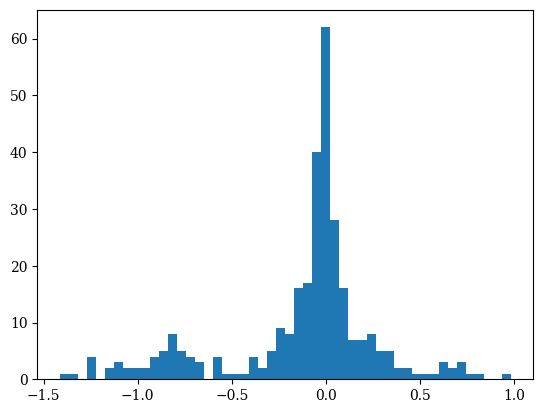

In [393]:
plt.hist(pred_hoas - t_h, bins=50)

In [500]:
new_structures.shape

(310, 48)

In [76]:
with open('MOR_843.cif', 'r') as f:
    lines = f.readlines()

In [503]:
def create_cif(ex_cif, atoms, target_cif):

    with open(ex_cif, 'r') as f:
        lines = f.readlines()

    cnt = 0
    for i in range(len(lines)):

        trgt = 'Al' if atoms[cnt] == 0 else 'Si'
        rplc = 'Al' if trgt =='Si' else 'Si'

        
        
        if lines[i].startswith('Si') or lines[i].startswith('Al'):

            lines[i] = lines[i].replace(trgt, rplc)
            cnt += 1 

    with open(target_cif, 'w') as f:
        f.writelines(lines)

In [504]:
for i in range(len(new_structures)):

    create_cif('MOR_843.cif', new_structures[i], f'GA_mors_2/MOR_{i}.cif')

In [92]:
create_cif('MOR_843.cif', new_structures[0], 'MOR_test.cif')

In [90]:
new_structures[0]

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [82]:
mask = [True if (i.startswith('Si') or i.startswith('Al')) else False for i in lines]

In [86]:
a = 'abvbv'


In [88]:
a.replace('c','q')

'abvbv'

In [78]:
lines = np.array(lines)

array(['Al1        Al     0.306     0.074     0.043     0.000\n',
       'Si        Si     0.303     0.311     0.044     0.000\n',
       'Si        Si     0.085     0.379     0.250     0.000\n',
       'Si        Si     0.085     0.223     0.250     0.000\n',
       'Si        Si     0.694     0.926     0.543     0.000\n',
       'Si        Si     0.697     0.689     0.544     0.000\n',
       'Si        Si     0.915     0.621     0.750     0.000\n',
       'Si        Si     0.915     0.777     0.750     0.000\n',
       'Si        Si     0.306     0.926     0.957     0.000\n',
       'Si        Si     0.303     0.689     0.956     0.000\n',
       'Si        Si     0.085     0.621     0.750     0.000\n',
       'Si        Si     0.085     0.777     0.750     0.000\n',
       'Si        Si     0.694     0.074     0.457     0.000\n',
       'Al2        Al     0.697     0.311     0.456     0.000\n',
       'Al3        Al     0.915     0.379     0.250     0.000\n',
       'Si        Si  

In [287]:
ga_instance.best_solutions.shape

(51, 48)

In [281]:
solution = ga_instance.best_solutions[-1]
atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
gen_net.eval()
with torch.no_grad():
    curr_hoa = gen_net.forward(atoms).item()

print(curr_hoa)

37.98651123046875


In [284]:
for i in ga_instance.population:
    solution = i#ga_instance.best_solutions[-1]
    atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
    gen_net.eval()
    with torch.no_grad():
        curr_hoa = gen_net.forward(atoms).item()
    
    print(curr_hoa)

37.98651123046875
48.372169494628906
47.99900436401367
42.333282470703125
49.31175994873047
44.43035888671875
47.089847564697266
48.574790954589844
45.050758361816406
47.031944274902344
47.91951370239258
45.04349136352539
45.733436584472656
45.861793518066406
46.840450286865234
42.127994537353516
44.01667785644531
49.86048889160156
44.97780227661133
42.496490478515625


In [185]:
hoa_opt._bonds.device

device(type='cuda', index=0)

In [186]:
iters=1000

In [189]:
ats, hat = hoa_opt.optimize(10, hoa=38, max_iter=iters, opt='Adam', lr=1e-4)
print(hat)

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.12it/s, Current HoA=39.7]

tensor([[39.2230],
        [33.5085],
        [39.6749],
        [41.3436],
        [45.1735],
        [41.5972],
        [34.5021],
        [43.8152],
        [50.0037],
        [38.2379]], device='cuda:0')


In [191]:
ats, hat = hoa_opt.optimize(10, hoa=25, max_iter=iters, opt='Adam', lr=1e-2)
print(hat)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.09it/s, Current HoA=30]

tensor([[30.6615],
        [28.5448],
        [28.5448],
        [28.5448],
        [29.7901],
        [30.3507],
        [28.5448],
        [33.0701],
        [32.2057],
        [34.9505]], device='cuda:0')


In [192]:
ats, hat = hoa_opt.optimize(10, hoa=30, max_iter=iters, opt='Adam', lr=1e-8)
print(hat)

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.91it/s, Current HoA=35.1]


tensor([[33.4223],
        [33.4854],
        [28.5448],
        [36.3917],
        [37.3276],
        [33.7882],
        [38.9818],
        [33.1784],
        [32.2017],
        [35.0433]], device='cuda:0')


In [193]:
ats, hat = hoa_opt.optimize(10, hoa=35, max_iter=iters, opt='Adam', lr=1e-8)
print(hat)

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.56it/s, Current HoA=38.8]


tensor([[44.6313],
        [35.8777],
        [36.8271],
        [35.6046],
        [38.5528],
        [37.1928],
        [44.3547],
        [35.3020],
        [34.0617],
        [38.0028]], device='cuda:0')


In [194]:
ats, hat = hoa_opt.optimize(10, hoa=40, max_iter=iters, opt='Adam', lr=1e-8)
print(hat)

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.66it/s, Current HoA=39.6]

tensor([[41.2032],
        [44.5488],
        [47.2542],
        [41.9937],
        [47.4708],
        [35.8685],
        [37.2309],
        [39.5766],
        [35.5848],
        [45.0170]], device='cuda:0')


In [195]:
ats, hat = hoa_opt.optimize(10, hoa=45, max_iter=iters, opt='Adam', lr=1e-8)
print(hat)

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.79it/s, Current HoA=44.5]


tensor([[41.6953],
        [44.5151],
        [40.8569],
        [42.9034],
        [37.4790],
        [43.5164],
        [47.5095],
        [40.7482],
        [38.8956],
        [45.9369]], device='cuda:0')


In [176]:
btch = next(iter(trainloader))

In [ ]:
btch[1].shape

In [68]:
edges[None].repeat(2,1,1).shape

torch.Size([2, 192, 1])

In [118]:
class GumbelSigmoid(nn.Module):
    def __init__(self):
        super(GumbelSigmoid, self).__init__()
        
    def forward(self, logit, temperature=1.0, hard=False):
        # Generate Gumbel noise
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(logit)))

        # Combine with logit and temperature
        z = (logit + gumbel_noise) / temperature

        # Apply sigmoid function
        sigmoid_output = torch.sigmoid(z)

        if hard:
            discrete_output = (sigmoid_output > 0.5).float()
            sigmoid_output = sigmoid_output + (discrete_output - sigmoid_output).detach()

        return sigmoid_output

In [120]:
gs = GumbelSigmoid()

In [140]:
gs(torch.tensor([[-1],[2],[0]]).float(), hard=True)

tensor([[0.],
        [1.],
        [1.]])